# Net Radiation

In [1]:
import numpy
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
def read_site_csv(csv_filename):
    csv_data = numpy.genfromtxt(csv_filename, delimiter=',', dtype=str)
    csv_v = csv_data[:, 1]
    csv_v = csv_v.astype(float)
    return csv_data[:, 0], csv_v


def mapping_comparison_single(site_obs, site_cal, fig_title='', axis_min=-200, axis_max=900):
    plt.figure(figsize=(8,8))
    
    nan_indices = numpy.isnan(site_obs) | numpy.isnan(site_cal)

    # 删除包含 NaN 值的位置
    x = site_obs[~nan_indices]
    y = site_cal[~nan_indices]
    
    # 绘制1:1参考线
    x_11 = numpy.arange(axis_min, axis_max + 1)
    y_11 = 1 * x_11
    plt.plot(x_11, y_11, color='k', linewidth=1, linestyle='--',)

    # 使用线性回归模型拟合数据
    model = LinearRegression()
    x = x.reshape(-1, 1)
    model.fit(x, y)
    y_pred = model.predict(x)
    xx = numpy.arange(axis_min, axis_max + 0.1, 0.05)
    yy_pred = model.coef_[0] * xx + model.intercept_
    
    # 绘制密度散点图
    xy = numpy.vstack([x.flatten(), y])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x_, y_, z = x[idx], y[idx], z[idx]
    z = (z-numpy.min(z))/(numpy.max(z)-numpy.min(z))*100
    plt.scatter(x_, y_, marker='o', c=z, s=8, cmap='turbo')
    
    # 绘制散点图和回归线
#     plt.scatter(x, y, color='b')
    plt.plot(xx, yy_pred, color='red')
    

    # 添加标签
    plt.title(fig_title)
    plt.xlabel('Net radiation observed at site (W/m²)')
    plt.ylabel('Net radiation calculated for ET (W/m²)')
    
    # 计算散点个数
    num = numpy.count_nonzero(~numpy.isnan(x))

    # 计算回归方程
    equation = f'y = {model.coef_[0]:.2f} * x + {model.intercept_:.2f}'

    # 计算评估指标
    r2 = r2_score(y, y_pred)
    rmse = numpy.sqrt(mean_squared_error(y, y_pred))
    bias = numpy.mean(y_pred - y)
    mae = mean_absolute_error(y, y_pred)

    print('N:', num)
    print('R²:', r2)
    print('RMSE:', rmse)
    print('Bias:', bias)
    print('MAE', mae)

    plt.annotate(f'N: {num:d}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=10)
    plt.annotate(equation, xy=(0.05, 0.90), xycoords='axes fraction', fontsize=10)
    plt.annotate(f'R²: {r2:.2f}', xy=(0.05, 0.85), xycoords='axes fraction', fontsize=10)
    plt.annotate(f'RMSE: {rmse:.2f}', xy=(0.05, 0.80), xycoords='axes fraction', fontsize=10)
    plt.annotate(f'Bias: {bias:.2f}', xy=(0.05, 0.75), xycoords='axes fraction', fontsize=10)
    plt.annotate(f'MAE: {mae:.2f}', xy=(0.05, 0.70), xycoords='axes fraction', fontsize=10)

    # 显示图形
    plt.xlim((axis_min, axis_max))
    plt.ylim((axis_min, axis_max))
#     plt.colorbar(label='density')
    plt.show()

    
def show_r_net_curve_week(site_name, week_idx, site_obs, site_cal, save_flag=0):
    # 30-min
    # good 30
    #     week_idx = 30

    week_obs_10min = site_obs[7*24*6*week_idx:7*24*6*(week_idx+1)]
    week_obs_hh = week_obs_10min[::3]

    week_cal_10min = site_cal[7*24*6*week_idx:7*24*6*(week_idx+1)]
    week_cal_hh = numpy.mean(week_cal_10min.reshape(-1, 3), axis=1)

    week_timelist_10min = obs_timelist[7*24*6*week_idx:7*24*6*(week_idx+1)]
    # week_timelist_hh = week_timelist_10min[::3]

    formatted_dates = []
    for date_string in week_timelist_10min:
        dt_object = datetime.strptime(date_string, "%Y-%m-%dT%H:%M:%SZ")
        formatted_date = dt_object.strftime("%-H:%M")
        formatted_dates.append(formatted_date)

    plt.figure(figsize=(18, 4))
    plt.plot(numpy.linspace(0, len(week_obs_hh), len(week_obs_hh)), week_obs_hh, '-', color='black', label='EC-site observed net radiation')
    plt.plot(numpy.linspace(0, len(week_cal_hh), len(week_cal_hh)), week_cal_hh, '-', color='red', label='Input net radiation for ET estimation')
    plt.plot(numpy.linspace(0, len(week_cal_hh), len(week_cal_hh)), week_cal_hh, '.', color='red')
    plt.xticks(numpy.linspace(0, len(week_obs_hh), int(len(week_obs_hh)/6)), formatted_dates[::18], rotation=45, ha='right')
    plt.ylabel(r'$W/m^2$', fontsize=14)
    plt.xlim(0,len(week_obs_hh))
    plt.ylim((-100,950))
    title_str = site_name + ' ' + (week_timelist_10min[0] + ' - ' + week_timelist_10min[-1]).replace('T',' ').replace('Z','')
    plt.title(title_str)
    plt.legend()
    if save_flag:
        plt.savefig(storage_folder + '/Rnet ' + title_str + '.png', dpi=300)
    else:
        plt.show()

In [3]:
storage_folder = '/disk2/workspace/20231122'

## CRK

N: 19661
R²: 0.9540598504001858
RMSE: 49.7447353880007
Bias: 3.1733551976818513e-14
MAE 30.263857635338752


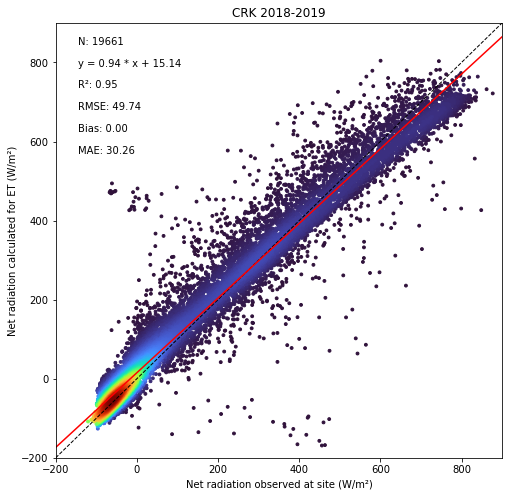

In [7]:
SITE_OBS_CSV = '/disk2/Data/FluxSite4ET/validation/CRK_2018_2019_Rnet.csv'
obs_timelist, site_obs = read_site_csv(SITE_OBS_CSV)
SITE_CAL_CSV = storage_folder + '/CRK_Rnet.csv'
cal_timelist, site_cal = read_site_csv(SITE_CAL_CSV)

mapping_comparison_single(site_obs, site_cal, 'CRK 2018-2019')

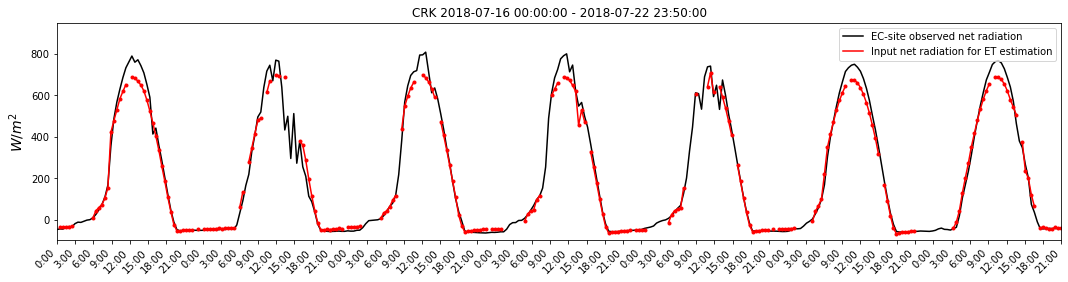

In [8]:
show_r_net_curve_week('CRK', 28, site_obs, site_cal, 1)

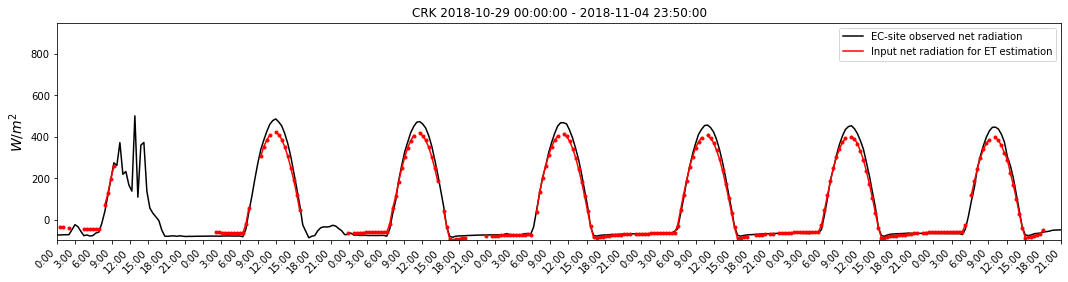

In [9]:
show_r_net_curve_week('CRK', 43, site_obs, site_cal, 1)

## GCK

N: 19448
R²: 0.9435113600224231
RMSE: 60.27650070006765
Bias: -1.5713195176661038e-14
MAE 35.17976582531115


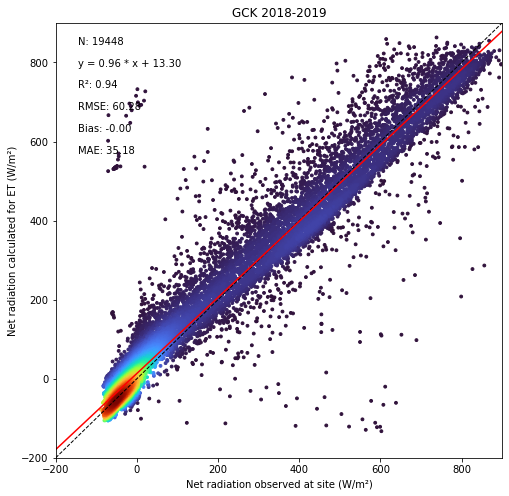

In [10]:
SITE_OBS_CSV = '/disk2/Data/FluxSite4ET/validation/GCK_2018_2019_Rnet.csv'
obs_timelist, site_obs = read_site_csv(SITE_OBS_CSV)
SITE_CAL_CSV = storage_folder + '/GCK_Rnet.csv'
cal_timelist, site_cal = read_site_csv(SITE_CAL_CSV)

mapping_comparison_single(site_obs, site_cal, 'GCK 2018-2019')

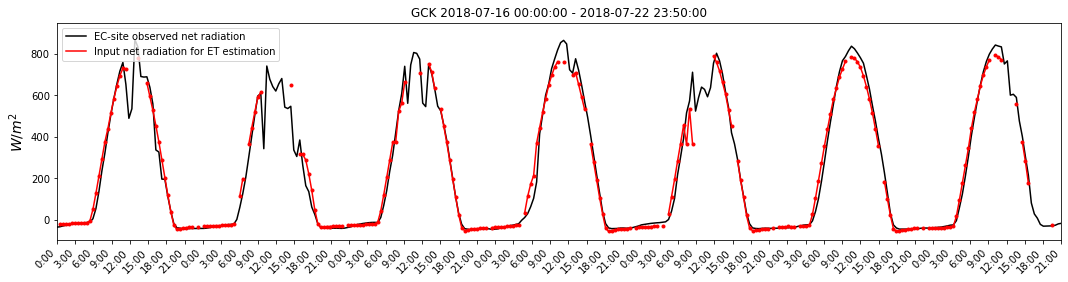

In [11]:
show_r_net_curve_week('GCK', 28, site_obs, site_cal, 1)

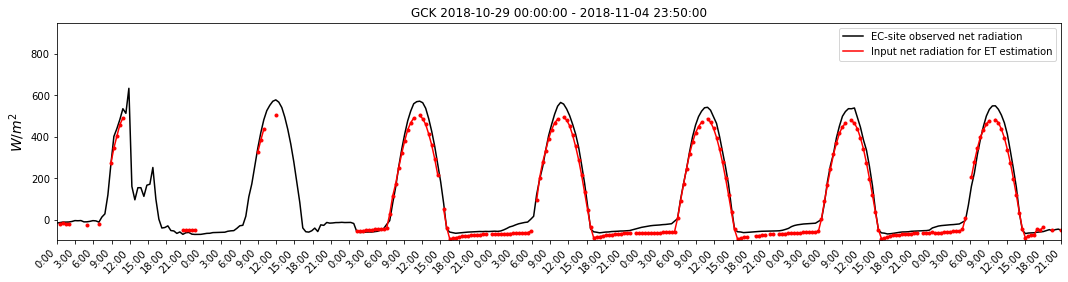

In [12]:
show_r_net_curve_week('GCK', 43, site_obs, site_cal, 1)

## GDK

N: 19309
R²: 0.942456348114539
RMSE: 60.07579419831674
Bias: 1.9877091726561486e-14
MAE 35.583647455919404


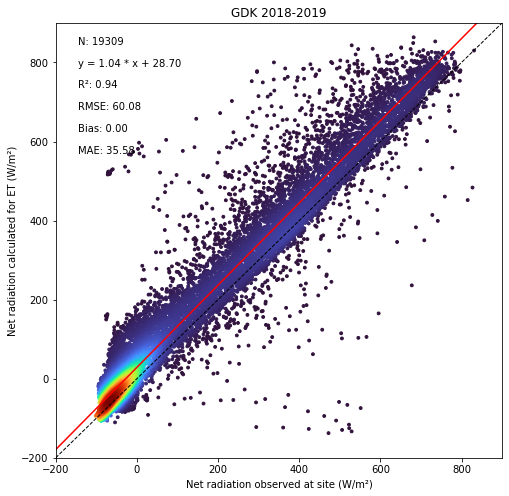

In [13]:
SITE_OBS_CSV = '/disk2/Data/FluxSite4ET/validation/GDK_2018_2019_Rnet.csv'
obs_timelist, site_obs = read_site_csv(SITE_OBS_CSV)
SITE_CAL_CSV = storage_folder + '/GDK_Rnet.csv'
cal_timelist, site_cal = read_site_csv(SITE_CAL_CSV)

mapping_comparison_single(site_obs, site_cal, 'GDK 2018-2019')

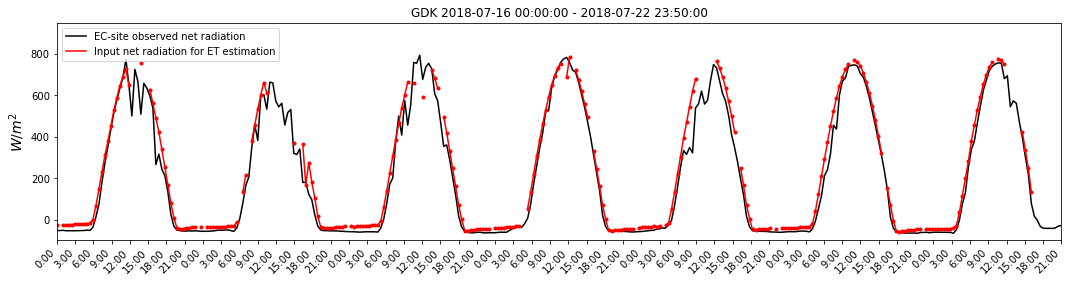

In [15]:
show_r_net_curve_week('GDK', 28, site_obs, site_cal, 1)

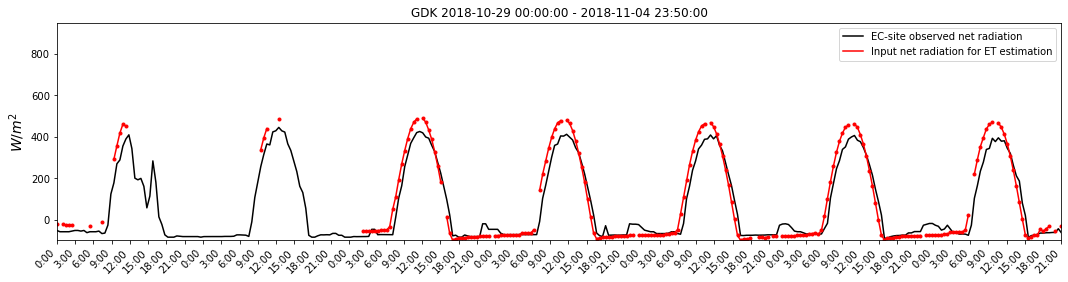

In [16]:
show_r_net_curve_week('GDK', 43, site_obs, site_cal, 1)

## TKY

N: 7388
R²: 0.8997062478806965
RMSE: 75.40932579251144
Bias: 1.3787683621896042e-14
MAE 46.701534746811795


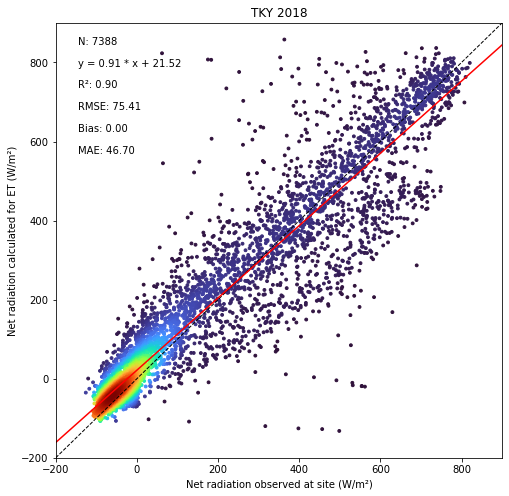

In [17]:
SITE_OBS_CSV = '/disk2/Data/FluxSite4ET/validation/TKY_2018_2019_Rnet.csv'
obs_timelist, site_obs = read_site_csv(SITE_OBS_CSV)
SITE_CAL_CSV = storage_folder + '/TKY_Rnet.csv'
cal_timelist, site_cal = read_site_csv(SITE_CAL_CSV)

mapping_comparison_single(site_obs, site_cal, 'TKY 2018')

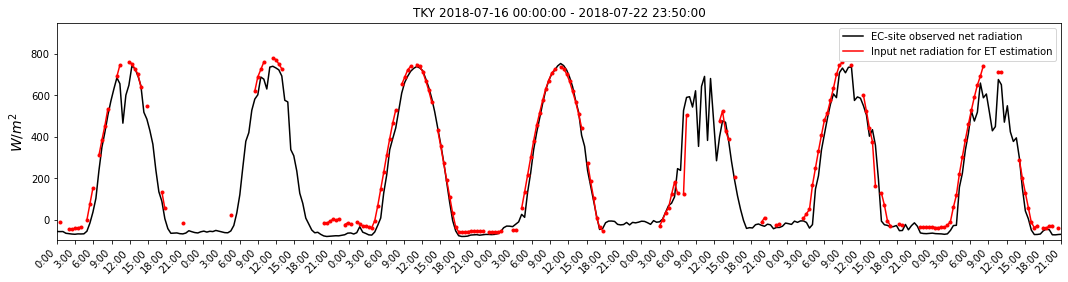

In [18]:
show_r_net_curve_week('TKY', 28, site_obs, site_cal, 1)

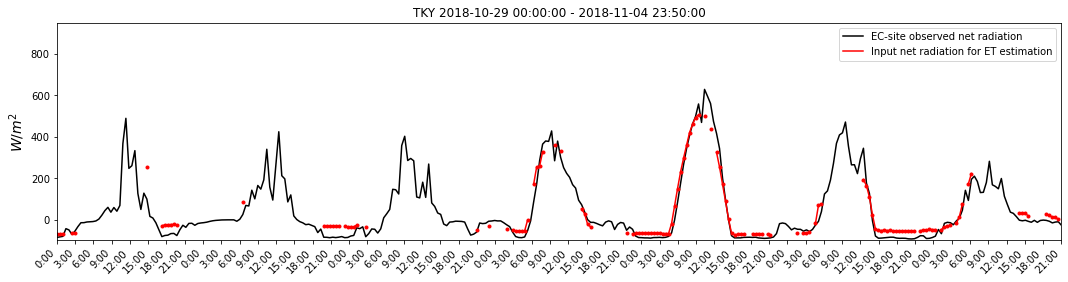

In [19]:
show_r_net_curve_week('TKY', 43, site_obs, site_cal, 1)